# Initial transfer learning CNN modeling in PyTorch

Adapted from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchmetrics
!pip install mlflow
!pip install pytorch-lightning==1.7.6

In [3]:
# Import basics
import os
import numpy as np
import pandas as pd
import time
import copy

# Import PyTorch
import torch
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

# Import PyTorch lightning and MLflow
import pytorch_lightning
import mlflow

# Import torchvision 
import torchvision
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, ConcatDataset

# Import torchmetrics
import torchmetrics

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}\npytorch_lighting version: {pytorch_lightning.__version__}")

PyTorch version: 1.12.1+cu113
torchvision version: 0.13.1+cu113
pytorch_lighting version: 1.7.6


In [4]:
cudnn.benchmark = True
plt.ion()   # interactive mode

## Initialize model

* Model must be defined before loading the data to resize the images to the required input size of the selected pre-trained model
* Num_classes is equal to 2 in our case (Mitosis vs. Nonmitosis). This will reset the last layer of the pre-trained model (usually a fully connected layer) to have output size = num_classes
* Feature_extract: If True, only update reshaped layer params. If False, model is finetuned and all model parameters are updated

In [5]:
model_name = 'resnet'
num_classes = 2
feature_extract = False

Helper function

In [6]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

Model selection function

In [7]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

Define and select model then write it to the device

In [8]:
model_ft, input_size = initialize_model(model_name=model_name, num_classes=num_classes, feature_extract=feature_extract, use_pretrained=True)

# write to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## PyTorch data setup

Change file_path to where the .zip file is in your Google Drive

In [9]:
import requests
import zipfile
from pathlib import Path
data_path = Path("data/") # unzip data to content/data
file_path = '/content/drive/MyDrive/Fourthbrain/Capstone/Image patch data/250px/Data_CMC_MEL_1.zip' # file path to .zip file in your Google Drive

In [10]:
# Unzip image patch data
with zipfile.ZipFile(file_path, "r") as zip_ref:
    print("Unzipping data") 
    zip_ref.extractall(data_path)

Unzipping data


### Load in data and split into train, validation, and test sets

**Hyperparameters**

In [11]:
batch_size = 64
num_workers = 2
random_state = 42

Set dataset and image path

In [12]:
dataset = 'Data_CMC_MEL_1'
image_path = '/content/data/' + dataset
train_dir = image_path+'/train'
test_dir = image_path+'/test'

* Load in train data from directory and randomly split (80/20) the train folder into training and validation sets
* Load in test data from directory separately
* Apply no transforms to any set yet except ToTensor

In [13]:
train_data = datasets.ImageFolder(root=train_dir, transform=transforms.ToTensor())

test_data = datasets.ImageFolder(root=test_dir, transform=transforms.ToTensor())

print(train_data)
print(test_data)

Dataset ImageFolder
    Number of datapoints: 29539
    Root location: /content/data/Data_CMC_MEL_1/train
    StandardTransform
Transform: ToTensor()
Dataset ImageFolder
    Number of datapoints: 10328
    Root location: /content/data/Data_CMC_MEL_1/test
    StandardTransform
Transform: ToTensor()


In [14]:
train_split = 0.8
training_examples = int(len(train_data)*train_split)
val_examples = len(train_data) - training_examples
train, val = torch.utils.data.random_split((train_data), 
                                            [training_examples, val_examples], 
                                                generator=torch.Generator().manual_seed(random_state))

In [ ]:
# Create data loader to calculate mean and std of train set only
dataset_loader = DataLoader(train, shuffle=False, num_workers=num_workers)

Function to get mean and standard deviation of the training data. Only run if needed (takes awhile)

In [ ]:
N_CHANNELS = 3 # color images, so three channels

def normalization_params(dataloader, N_CHANNELS):
  mean = torch.zeros(N_CHANNELS)
  std = torch.zeros(N_CHANNELS)

  for inputs, labels in dataloader:
    for i in range(N_CHANNELS):
      mean[i] += inputs[:,i,:,:].mean().item()
      std[i] += inputs[:,i,:,:].std().item()

  mean /= len(train)
  std /= len(train)
  return mean, std

In [ ]:
mean, std = normalization_params(dataset_loader, N_CHANNELS)

In [ ]:
print(mean)
print(std)

### Define PyTorch transform

Entire train folder directory stats
* mean of MEL 1 (128 px) training data = [0.7358, 0.5185, 0.6233], mean of MEL 1(250 px) training data = [0.7439, 0.5272, 0.6297]
* std of MEL 1 (128 px) training data = [0.1470, 0.1610, 0.1329], std of MEL 1 (250 px) training data [0.1433, 0.1633, 0.1339]

Stats of train set after splitting into train/val
* mean of MEL 1 (250 px) training data = [0.7438, 0.5271, 0.6297]
* std of MEL 1 (250 px) training data =[0.1433, 0.1634, 0.1339]


In [15]:
mean = [0.7438, 0.5271, 0.6297] # mean of training set (after splitting)
std = [0.1433, 0.1634, 0.1339] # standard deviation of training set (after splitting)

Resize, normalize, and transform data to tensors (no augmentation for now)

In [16]:
# Write transform dictionary
data_transforms = {
    'train': transforms.Compose([
      # Resize the images to input_size of pre-trained model
      transforms.Resize(input_size),
      # Flip the images randomly on the horizontal, p = probability of flip, 0.5 = 50% chance
      transforms.RandomHorizontalFlip(p=0.5), 
      # Turn the image into a torch.Tensor, this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
      transforms.ToTensor(), 
      # normalize data with proper normalization values
      transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
      # Resize the images to input_size of pre-trained model
      transforms.Resize(input_size),
      # Turn the image into a torch.Tensor
      transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
      # normalize data with proper normalization values
      transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
      # Resize the images to input_size of pre-trained model
      transforms.Resize(input_size),
      # Turn the image into a torch.Tensor
      transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
      # normalize data with proper normalization values
      transforms.Normalize(mean, std)
    ])
}

Apply transforms to training, validation, and test sets

In [17]:
train.dataset.transform = data_transforms['train']
val.dataset.transform = data_transforms['val']
test_data.transform = data_transforms['test']


### Create PyTorch dataloaders

Create dictionary of train, validation, and test sets and specify whether to shuffle the data in the dataloader

In [18]:
image_datasets = {'train': [train, True],
                    'val': [val, True],
                        'test': [test_data, False]} # usually don't shuffle test data

dataset_sizes = {x: len(image_datasets[x][0]) for x in ['train','val','test']}

Create dataloaders

In [19]:
dataloaders = {x: DataLoader(image_datasets[x][0], 
                                batch_size=batch_size, 
                                    num_workers=num_workers, 
                                        shuffle=image_datasets[x][1])
                for x in ['train','val','test']}

### Visualize data

In [20]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [21]:
# Get a batch of training data and subset to just 4 examples
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[:4]
inputs = np.clip(inputs, 0, 1)
classes = classes[:4]

In [22]:
# Get class names
class_names = train_data.classes

In [23]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

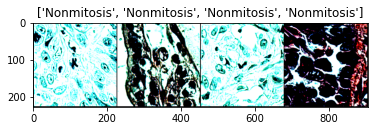

In [24]:
imshow(out, title=[class_names[x] for x in classes])

## PyTorch modeling setup

**Hyperparameters**

In [ ]:
# Hyperparameters for training
learning_rate = 0.01
momentum = 0.9
step_size = 7 # decrease learning rate by factor gamma every step size epochs
gamma = 0.1
num_epochs = 25

### Model training definition

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    # Set up dictionary to track train and validation loss and accuracy per epoch
    model_track = {'epoch': [],
                  'phase': [],
                  'loss': [],
                  'acc': []
                  }
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # update model tracking dictionary
            model_track['epoch'].append(epoch)
            model_track['phase'].append(phase)
            model_track['loss'].append(epoch_loss)
            model_track['acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, model_track

### Visualizing model predictions

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Set the optimizer

In [ ]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=learning_rate, momentum=momentum)

### Set the loss function and learning rate scheduler

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Decay LR by factor 'gamma' every 'step_size' epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=step_size, gamma=gamma)

## Run the model

In [ ]:
model_ft, model_track = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs)

Epoch 0/24
----------
train Loss: 0.4574 Acc: 0.7912
val Loss: 0.4145 Acc: 0.8145

Epoch 1/24
----------
train Loss: 0.3112 Acc: 0.8668
val Loss: 0.4265 Acc: 0.8097

Epoch 2/24
----------
train Loss: 0.2304 Acc: 0.9017
val Loss: 0.5715 Acc: 0.8072

Epoch 3/24
----------
train Loss: 0.1612 Acc: 0.9347
val Loss: 0.5980 Acc: 0.7879

Epoch 4/24
----------
train Loss: 0.1267 Acc: 0.9510
val Loss: 0.5218 Acc: 0.8162

Epoch 5/24
----------
train Loss: 0.0900 Acc: 0.9658
val Loss: 0.5446 Acc: 0.8370

Epoch 6/24
----------
train Loss: 0.0728 Acc: 0.9733
val Loss: 0.6417 Acc: 0.8411

Epoch 7/24
----------
train Loss: 0.0221 Acc: 0.9923
val Loss: 0.6486 Acc: 0.8534

Epoch 8/24
----------
train Loss: 0.0068 Acc: 0.9990
val Loss: 0.6853 Acc: 0.8536

Epoch 9/24
----------
train Loss: 0.0036 Acc: 0.9996
val Loss: 0.7122 Acc: 0.8536

Epoch 10/24
----------
train Loss: 0.0025 Acc: 0.9999
val Loss: 0.7712 Acc: 0.8517

Epoch 11/24
----------
train Loss: 0.0024 Acc: 0.9997
val Loss: 0.8020 Acc: 0.8512

Ep

## Save model

**Warning:** Make sure to change model name so it doesn't overwrite previous models

In [ ]:
path = '/content/drive/MyDrive/Fourthbrain/Capstone/models/' # path in your Google Drive you want to save models to
model_name = 'model_baseline_v0' # model name
torch.save(model_ft, path + model_name + '.pth')
torch.save(model_ft.state_dict(), path + model_name + '_weights.pth')

Save training and validation losses + accuracy over epochs in a csv

In [ ]:
track_df = pd.DataFrame(model_track)
track_df.to_csv(path + model_name + '_training_results.csv')

## Evaluate model on test set

1.   Specify whether to load model or use model just trained
2.   If loading, specify path to models folder and model name


In [25]:
load_model = True
path = '/content/drive/MyDrive/Fourthbrain/Capstone/models/'
model_name = 'model_baseline_v0'

In [26]:
if load_model:
  model_ft = torch.load(path + model_name + '.pth')
else:
  model_ft

Define loss function (match loss function used during training)

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [28]:
loss_fn = nn.CrossEntropyLoss()

### Get lists of labels and predictions to use scikit-learn metrics

In [29]:
torch.manual_seed(random_state)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, auc, roc_curve
def get_predictions(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):
  
  # initialize lists to track labels, predictions, and scores
  labels = []
  predictions = []
  scores = []

  # initialize loss
  loss = 0

  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      # Ensure data tensors are on right device
      X, y = X.to(device), y.to(device)
      # Make predictions with the model
      outputs = model(X)
      # Map outputs to probabilities with Softmax
      m = nn.Softmax(dim=1)
      p = m(outputs)
      probs, y_pred = torch.max(p, 1)

      # Accumulate the loss values per batch
      loss += loss_fn(outputs, y)

      # Append lists
      labels = labels + y.tolist()
      predictions = predictions + y_pred.tolist()
      scores = scores + probs.tolist()

    # Scale loss to find the average loss per batch
    loss /= len(data_loader)

    # Get metrics w/sklearn (positive class = 0)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, pos_label=0)
    prec = precision_score(labels, predictions, pos_label=0)
    rec = recall_score(labels, predictions, pos_label=0)

    model_dict = {"model_name": model.__class__.__name__, # only works when model was created with a class
            "test_loss": loss.item(),
            "test_acc": acc,
            "F1 Score": f1,
            "Precision": prec,
            "Recall": rec
    }

  return labels, predictions, scores, model_dict
        

In [30]:
labels, predictions, scores, model_dict = get_predictions(model=model_ft, data_loader = dataloaders['test'], loss_fn=loss_fn)
print(model_dict)

{'model_name': 'ResNet', 'test_loss': 0.6358661651611328, 'test_acc': 0.854570100697134, 'F1 Score': 0.7755528989838614, 'Precision': 0.763235294117647, 'Recall': 0.7882746051032807}


Print out classification report

In [31]:
from sklearn.metrics import classification_report

target_names = test_data.classes # get target names from the test dataset (not test dataloader)

print(classification_report(labels, predictions, target_names=target_names))

              precision    recall  f1-score   support

     Mitosis       0.76      0.79      0.78      3292
  Nonmitosis       0.90      0.89      0.89      7036

    accuracy                           0.85     10328
   macro avg       0.83      0.84      0.83     10328
weighted avg       0.86      0.85      0.86     10328



Save model test results to a csv

In [150]:
test_results_df = pd.DataFrame(model_dict, index = np.arange(0,1))
test_results_df.to_csv(path + model_name +'_test_results.csv')

### Look at ROC and AUC

The area under the curve (AUC) is 0.3149081153201346


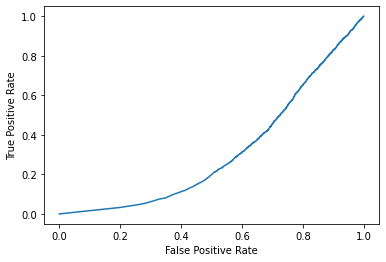

In [34]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

# positive label = 0 (Mitosis)
fpr, tpr, thresholds = roc_curve(labels, scores, pos_label=0)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

print('The area under the curve (AUC) is {}'.format(auc(fpr, tpr)))

### Confusion matrix

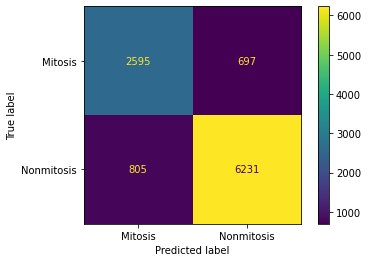

In [165]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(labels, predictions)
cm_display = ConfusionMatrixDisplay(cm, display_labels=test_data.classes).plot()